**CURSO**: *Machine Learning* en Geociencias<br />
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from several sources such as [pyGAM](https://pygam.readthedocs.io/en/latest/index.html), [Tesi Xiao](https://tesixiao.github.io/teaching/2022-winter-142a), [Pablo Oberhauser](https://codeburst.io/pygam-getting-started-with-generalized-additive-models-in-python-457df5b4705f). Every effort has been made to trace copyright holders of the materials used in this notebook. The author apologizes for any unintentional omissions and would be pleased to add an acknowledgment in future editions.

In [ ]:
import pip
pip.main(['install','pygam'])

# 15: Generalized Additive Models (GAMs)

Los Modelos Aditivos Generalizados son modelos semi-parametricos de suavizado

In [3]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [59]:
from pygam import LinearGAM,LogisticGAM,s,l, f
from pygam.datasets import wage,mcycle,default
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [13]:
X,y=wage()

In [14]:
print(X)
print(y)

[[2.006e+03 1.800e+01 0.000e+00]
 [2.004e+03 2.400e+01 3.000e+00]
 [2.003e+03 4.500e+01 2.000e+00]
 ...
 [2.005e+03 2.700e+01 0.000e+00]
 [2.005e+03 2.700e+01 2.000e+00]
 [2.009e+03 5.500e+01 1.000e+00]]
[ 75.04315402  70.47601965 130.98217738 ...  66.22940829  87.98103279
  90.48191336]


A continuacion vamos a instanciar un modelo lineal aditivo con una funcion *spline* para los dos primeras variables con 10 grados de libertad para cada una, y un factor para la tercera, que por defecto presenta 5 grados de libertad.

In [17]:
model=LinearGAM(s(0,n_splines=10)+s(1,n_splines=10)+f(2))
model.fit(X,y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [18]:
model.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     17.3966
Link Function:                     IdentityLink Log Likelihood:                                -24116.1826
Number of Samples:                         3000 AIC:                                            48269.1583
                                                AICc:                                           48269.3977
                                                GCV:                                             1248.7197
                                                Scale:                                           1235.6924
                                                Pseudo R-Squared:                                   0.2942
Feature Function                  Lam

En este caso tenemos por defecto (10+10+5)=25 grados de libertad (*Rank*) con una penalizacion de 0.6 cada uno (lam=0.6), lo cual reduce los grados de libertad a aproximadamente 15. 

Por defecto las funciones *spline* tiene una penalizacion en la segunda derivada con el fin de suavizar la funcion y evitar el sobreajuste, y los *f()* y los terminos lineales *l()*.

A continuacion se realizara un *grid-search* para optimizar el valor de *lam*. Se van a definir 5 valores en un dominio de -3 y 5, como son tres variables se evaluaran un total de 5*5*5=125 modelos

In [20]:
lam=np.logspace(-3,5,5)
lams=[lam]*3

model.gridsearch(X,y,lam=lams)
model.summary()

100% (125 of 125) |######################| Elapsed Time: 0:00:13 Time:  0:00:13


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     10.4649
Link Function:                     IdentityLink Log Likelihood:                                -24117.6524
Number of Samples:                         3000 AIC:                                            48258.2347
                                                AICc:                                           48258.3303
                                                GCV:                                             1244.1061
                                                Scale:                                           1236.2968
                                                Pseudo R-Squared:                                   0.2922
Feature Function                  Lam

Es posible entonces graficar la dependencia parcial de cada termino en nuestro modelo, en este caso utilizaremos el intervalo de confianza del 95%.

<Figure size 640x480 with 0 Axes>

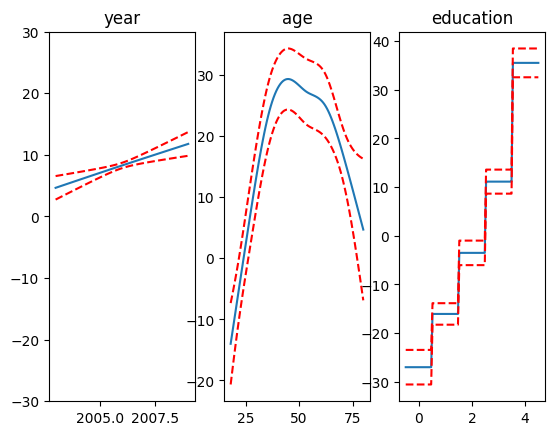

In [25]:
plt.figure();
fig,axs=plt.subplots(1,3);

titles=['year','age','education']

for i, ax in enumerate(axs):
    XX = model.generate_X_grid(term=i)
    ax.plot(XX[:,i],model.partial_dependence(term=i,X=XX))
    ax.plot(XX[:,i],model.partial_dependence(term=i, X=XX, width=0.95)[1],c='r',ls='--')
    if i==0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])    

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


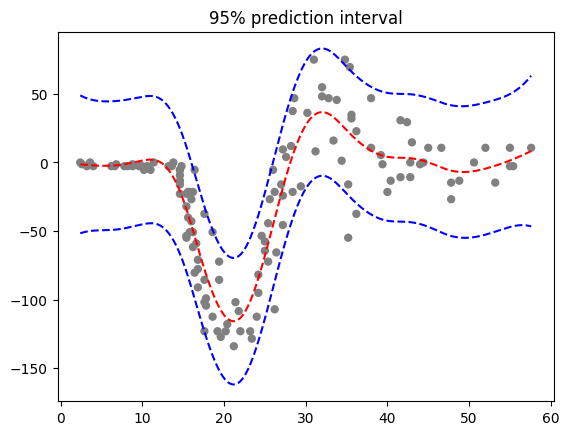

In [27]:
X, y = mcycle(return_X_y=True)

gam = LinearGAM(n_splines=25).gridsearch(X, y)
XX = gam.generate_X_grid(term=0, n=500)

plt.plot(XX, gam.predict(XX), 'r--')
plt.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--')

plt.scatter(X, y, facecolor='gray', edgecolors='none')
plt.title('95% prediction interval');

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Text(0.5, 1.0, 'draw samples from the posterior of the coefficients')

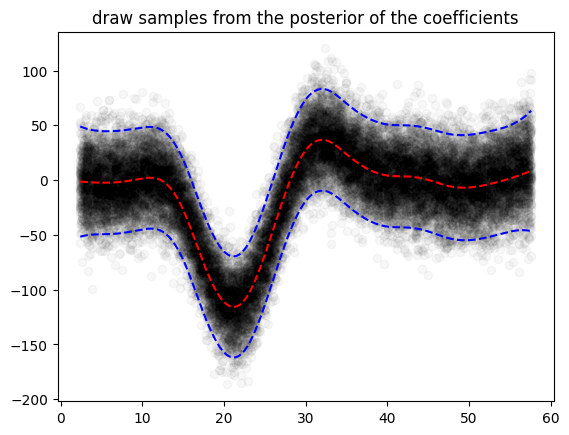

In [28]:
for response in gam.sample(X, y, quantity='y', n_draws=50, sample_at_X=XX):
    plt.scatter(XX, response, alpha=.03, color='k')
plt.plot(XX, gam.predict(XX), 'r--')
plt.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--')
plt.title('draw samples from the posterior of the coefficients')

## Logistic GAM

Main parameters to keep in mind are:

n_splines , lam , and constraints

n_splines refers to the number of splines to use in each of the smooth function that is going to be fitted.

lam is the penalization term that is multiplied to the second derivative in the overall objective function.

constraints is a list of constraints that allows the user to specify whether a function should have a monotonically constraint. This needs to be a string in [‘convex’, ‘concave’, ‘monotonic_inc’, ‘monotonic_dec’,’circular’, ‘none’]

The default parameters that are being used in the model presented above are the following….

n_splines = 25

lam = 0.6

constraints = None

100% (11 of 11) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


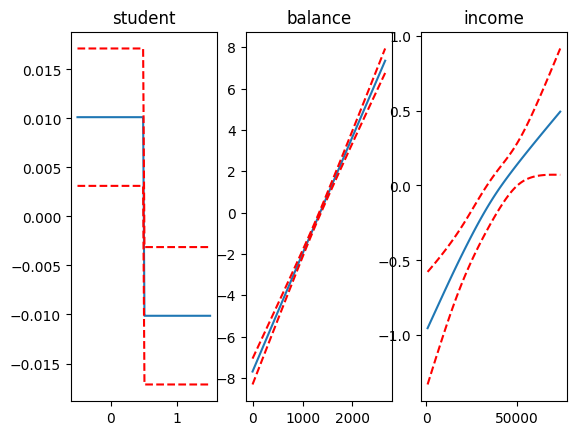

In [38]:
X, y = default(return_X_y=True)

model = LogisticGAM(f(0) + s(1, constraints='monotonic_inc') + s(2)).gridsearch(X, y)

fig, axs = plt.subplots(1, 3)
titles = ['student', 'balance', 'income']

for i, ax in enumerate(axs):
    XX = model.generate_X_grid(term=i)
    pdep, confi = model.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

In [34]:
model.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.8047
Link Function:                        LogitLink Log Likelihood:                                   -788.877
Number of Samples:                        10000 AIC:                                             1585.3634
                                                AICc:                                             1585.369
                                                UBRE:                                               2.1588
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.4598
Feature Function                  Lam

In [36]:
model.accuracy(X,y)

0.9739

In [40]:
data = load_breast_cancer()
#keep first 6 features only
df = pd.DataFrame(data.data, columns=data.feature_names)[['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness', 'mean compactness']]
target_df = pd.Series(data.target)
df.describe()

mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  
count       569.000000        569.000000  
mean          0.096360          0.104341  
std           0.014064          0.052813  
min           0.052630          0.019380  
25%           0.086370          0.064920  
50%           0.095870          0.092630  
75%           0.105300          0.130400  
max           0.163400          0.345400

In [41]:
X = df[['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness', 'mean compactness']]
y = target_df
#Fit a model with the default parameters
gam = LogisticGAM().fit(X, y)

In [42]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     19.4476
Link Function:                        LogitLink Log Likelihood:                                   -54.0256
Number of Samples:                          569 AIC:                                              146.9464
                                                AICc:                                             148.5483
                                                UBRE:                                               2.2856
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.8562
Feature Function                  Lam

In [43]:
gam.accuracy(X, y)

0.9560632688927944

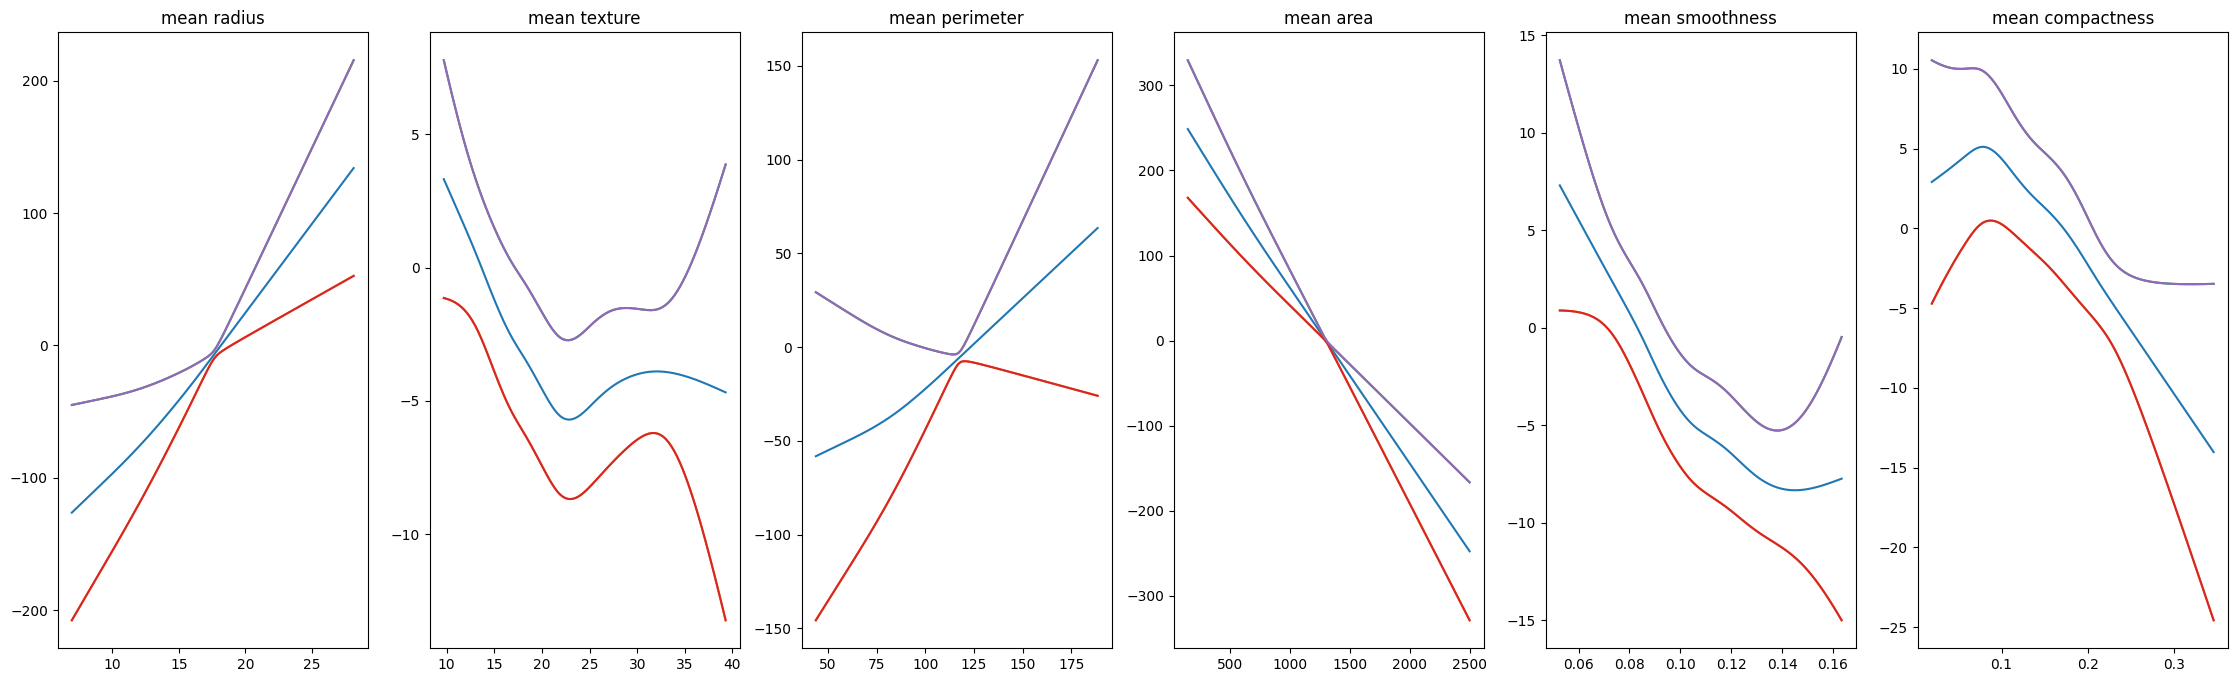

In [51]:
plt.rcParams['figure.figsize'] = (28, 8)
fig, axs = plt.subplots(1, len(data.feature_names[0:6]))
titles = data.feature_names
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi)
    ax.plot(XX[:, i], confi)
    ax.set_title(titles[i])
plt.show()




In [52]:
lambda_ = 0.6
n_splines = [25, 6, 25, 25, 6, 4] 
constraints = None
gam = LogisticGAM(constraints=constraints, 
          lam=lambda_,
         n_splines=n_splines).fit(X, y)

In [53]:
gam.accuracy(X,y)

0.9507908611599297

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
gam = LogisticGAM().fit(X_train, y_train)

In [60]:
predictions = gam.predict(X_test)
print("Accuracy: {} ".format(accuracy_score(y_test, predictions)))
probas = gam.predict_proba(X_test)      
print("Log Loss: {} ".format(log_loss(y_test, probas)))

Accuracy: 0.9574468085106383 
Log Loss: 0.12242562384678927 


In [62]:
lambda_ = [0.6, 0.6, 0.6, 0.6, 0.6, 0.6]
n_splines = [4, 14, 4, 6, 12, 12] 
constraints = [None, None, None, None, None, None]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
gam = LogisticGAM(constraints=constraints, lam=lambda_,n_splines=n_splines).fit(X_train, y_train)
predictions = gam.predict(X_test)
print("Accuracy: {} ".format(accuracy_score(y_test, predictions)))
probas = gam.predict_proba(X_test)      
print("Log Loss: {} ".format(log_loss(y_test, probas)))

Accuracy: 0.9680851063829787 
Log Loss: 0.1070767314390812 
